### Long Short Term Memory(LSTM) Prediction



In [131]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append("../..")
from utils.StockPricesProcess import load_prices_df, add_lags

# defining the path to the stock prices data and the date range
df_path = "../../data/stock_prices/yfinance/AAPL_prices.csv"
start_date_string = "2022-01-01"
end_date_string = "2023-01-01"

# Load stock prices and add lags using functions from StockPricesProcess.py
stock_data = load_prices_df(path=df_path, start_date_string=start_date_string, end_date_string=end_date_string)
stock_data = add_lags(stock_data=stock_data.copy(), numLags=3)
print(stock_data.shape)

stock_data.head(2)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(251, 8)


,Open,High,Low,Close,Volume,Close_Lag1,Close_Lag2,Close_Lag3
Date,,,,,,,,
2022-01-03 05:00:00+00:00,175.597058,180.583650,175.478569,179.724564,104487900,179.724564,179.724564,179.724564
2022-01-04 05:00:00+00:00,180.336790,180.642895,176.870854,177.443573,99310400,179.724564,179.724564,179.724564


Visualize the adjusted close prices over time using a line plot.

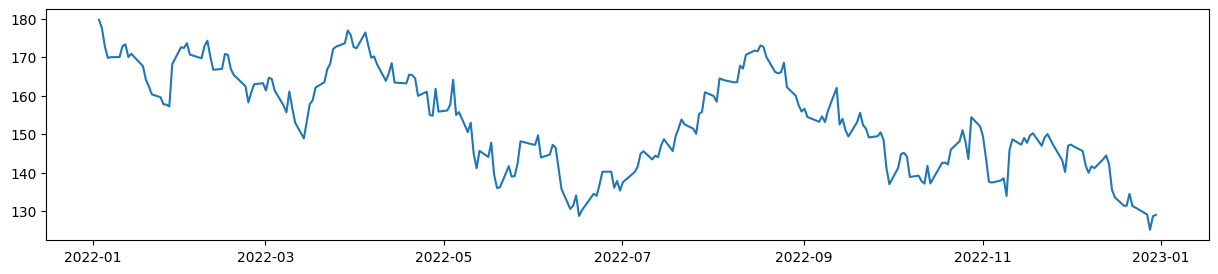

In [132]:
plt.figure(figsize=(15, 3))
plt.plot(stock_data.index, stock_data['Close'],)

Convert the 'Date' column to a datetime format using the specified format ("%d/%m/%Y"). Sort the dataset based on the 'Date' column to ensure it's in chronological order.


- The target variable (output_var) is set to the "Adjusted_close" column from the AAPL dataset. This is the variable we aim to predict.

- The features variable (features) is a list of columns that will be used as input features for training the model. These features include "Close," "Open," "High," "Low," and "Volume."

In [133]:
from sklearn.preprocessing import MinMaxScaler

features = ["Close_Lag1", "Close_Lag2", "Close_Lag3", "Volume"]
output_var = stock_data["Close"]

scaler = MinMaxScaler()
stock_data[features] = scaler.fit_transform(stock_data[features])
stock_data[features] = pd.DataFrame(data=stock_data[features], columns=features, index=stock_data.index)

stock_data[features].head()


,Close_Lag1,Close_Lag2,Close_Lag3,Volume
Date,,,,
2022-01-03 05:00:00+00:00,1.000000,1.000000,1.000000,0.470076
2022-01-04 05:00:00+00:00,1.000000,1.000000,1.000000,0.434951
2022-01-05 05:00:00+00:00,0.958181,1.000000,1.000000,0.402573
2022-01-06 05:00:00+00:00,0.871647,0.958181,1.000000,0.418627
2022-01-07 05:00:00+00:00,0.818785,0.871647,0.955227,0.349465


In [134]:
# https://www.analyticsvidhya.com/blog/2021/10/machine-learning-for-stock-market-prediction-with-step-by-step-implementation/


from sklearn.model_selection import TimeSeriesSplit

timesplit = TimeSeriesSplit(n_splits=10)

for train_index, test_index in timesplit.split(stock_data):
    X_train, X_test = stock_data.iloc[:len(train_index)], stock_data.iloc[len(train_index): (len(train_index)+len(test_index))]
    y_train, y_test = output_var.iloc[:len(train_index)].values.ravel(), output_var.iloc[len(train_index): (len(train_index)+len(test_index))].values.ravel()

In [135]:
trainX = np.array(X_train)
testX = np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])

In [136]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

lstm = Sequential()
lstm.add(LSTM(32, input_shape=(1, trainX.shape[1]), activation="relu", return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss="mean_squared_error", optimizer="adam")
lstm.fit(X_train, y_train, epochs=150, batch_size=1, verbose=1, shuffle=False)

Epoch 1/150
229/229 [==============================] - 1s 693us/step - loss: 3413.8262
Epoch 2/150
229/229 [==============================] - 0s 631us/step - loss: 2.0871
Epoch 3/150
229/229 [==============================] - 0s 690us/step - loss: 2.1044
Epoch 4/150
229/229 [==============================] - 0s 632us/step - loss: 2.1202
Epoch 5/150
229/229 [==============================] - 0s 635us/step - loss: 2.1405
Epoch 6/150
229/229 [==============================] - 0s 640us/step - loss: 2.1636
Epoch 7/150
229/229 [==============================] - 0s 637us/step - loss: 2.1873
Epoch 8/150
229/229 [==============================] - 0s 654us/step - loss: 2.2104
Epoch 9/150
229/229 [==============================] - 0s 638us/step - loss: 2.2322
Epoch 10/150
229/229 [==============================] - 0s 629us/step - loss: 2.2525
Epoch 11/150
229/229 [==============================] - 0s 636us/step - loss: 2.2728
Epoch 12/150
229/229 [==============================] - 0s 646us/step -

In [137]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred= lstm.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2_gb = r2_score(y_test, y_pred)

print(f"Results for training the model with LSTM without incorporating sentiment scores")
print(f'Mean Absolute Error (MAE) - LSTM: {mae}')
print(f'Mean Squared Error (MSE) - LSTM: {mse}')
print(f'Root Mean Squared Error (RMSE) - LSTM: {rmse}')
print(f'R-squared (R2) Score - LSTM: {r2_gb}')

1/1 [==============================] - 0s 154ms/step
Results for training the model with LSTM without incorporating sentiment scores
Mean Absolute Error (MAE) - LSTM: 0.5391453829678622
Mean Squared Error (MSE) - LSTM: 0.49605777105369436
Root Mean Squared Error (RMSE) - LSTM: 0.7043136879641729
R-squared (R2) Score - LSTM: 0.9896602947443446


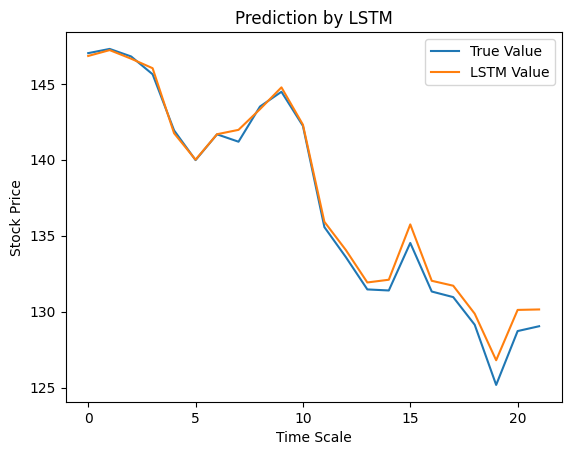

In [138]:
plt.plot(y_test, label="True Value")
plt.plot(y_pred, label="LSTM Value")
plt.title("Prediction by LSTM")
plt.xlabel("Time Scale")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

### References

- [LSTM Layer Documentation](https://keras.io/api/layers/recurrent_layers/lstm/)

- [Sequential Model Documentation](https://keras.io/guides/sequential_model/)

- [Compilation and Training Documentation](https://keras.io/api/models/model_training_apis/)

- [Time Series Prediction Using LSTM](https://towardsdatascience.com/time-series-prediction-using-lstm-with-pytorch-f7e75fa7d8f6)

- [A Gentle Introduction to Long Short-Term Memory Networks](https://machinelearningmastery.com/gentle-introduction-long-short-term-memory-networks-experts/)

- https://www.analyticsvidhya.com/blog/2021/10/machine-learning-for-stock-market-prediction-with-step-by-step-implementation/
